# WGAN on MNIST 

### 本章節內容大綱
* [WGAN原理](#WGAN原理)
* [1-Lipschitz 實作](#1-Lipschitz-實作)

# WGAN原理

在vanilla GAN裡面，是使用JS divergence來衡量兩個分佈的遠近，不過JS divergence有一個缺點，就是當資料沒有交集的時候，它的值永遠會是log2；而生成資料與真實資料皆可看成高維空間中的低維manifolds(流形)，他們的交集基本上可以被忽略（或者說可以找到一個discriminator將其輕易得分開），那將會使JS divergence永遠維持在log2，而讓generator的gradient停在0無法更新。

<br>
<img src="https://hackmd.io/_uploads/SJJPXXWla.png" width=500  />

WGAN作者使用了Wasserstein distance(又作Earth mover's distance，EMD)來取代原本的JS divergence，簡單來說，EMD就是將P分佈變成Q分佈所需要的最小代價：

$$B(\gamma) = \sum_{x_p,x_q}\gamma(x_p,x_q)||x_p-x_q|| $$
$$W(P,Q) = \min_{\gamma \in \Pi} B(\gamma)$$

不過這個方法要窮舉所有的moving plan，WGAN作者透過複雜的數學推導，將下式作為 discriminator 的 objective function 直接衡量 $P_G$ 與 $P_{data}$ 之間的 Wasserstein distance：

$$V(G,D) = \max_{D \in 1-Lipschitz} (E_{x \sim P_{data}}\;[D(x)] - E_{x \sim P_{G}}\;[D(x)])$$

這邊的1-Lipschitz function簡單來說就是要discriminator變得平滑，讓generator能夠依循它的gradient更新。

# Import 

In [1]:
!pip install imageio

In [2]:
''' basic package '''
import os
import time
import imageio
import glob
from IPython.display import display, Image

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import (
    Dense, Conv2DTranspose, Conv2D, BatchNormalization,
    LeakyReLU, Dropout, Reshape, Flatten
)

from tensorflow.keras.losses import BinaryCrossentropy

from tensorflow.keras.optimizers import Adam, RMSprop

os.environ["CUDA_VISIBLE_DEVICES"] = '0'

# Config 

In [3]:
BATCH_SIZE = 128
BUFFER_SIZE = 60000  # tf2.0 的 shuffle 需要定義「抽籤桶」要多大，設 60000 意指全部的資料
z_dim = 100  # latent/noise vector z 的維度
EPOCHS = 50
learning_rate = 1e-4
num_examples_to_generate = 16
clip = [-0.05, 0.05]  # 將 weight 限制在 - 0.05 ~ + 0.05 之間


(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')

# 將圖片正規化至 [-1 ~ 1]
train_images = (train_images - 127.5) / 127.5

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

2023-09-27 09:40:36.204366: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-27 09:40:36.865070: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10417 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:0c:00.0, compute capability: 6.1


# Train 

### 定義 generator & discriminator 

In [4]:
# Define model


class Generator(Model):
    def __init__(self, z_dim):
        super(Generator, self).__init__()

        self.model = Sequential()

        # [z_dim] => [7, 7, 128]
        self.model.add(Dense(7 * 7 * 128, input_shape=(z_dim,)))
        self.model.add(LeakyReLU())
        self.model.add(Reshape((7, 7, 128)))

        # [7, 7, 128] => [14, 14, 64]
        self.model.add(Conv2DTranspose(64, 5, strides=2, padding='same'))
        self.model.add(LeakyReLU())

        # [14, 14, 64] => [28, 28, 1]
        self.model.add(Conv2DTranspose(1, 5, strides=2, padding='same', activation='tanh'))

    def call(self, x):
        return self.model(x)


class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = Sequential()

        # [28, 28, 1] => [14, 14, 64]
        self.model.add(Conv2D(64, 5, strides=2, padding='same', input_shape=(28, 28, 1)))
        self.model.add(LeakyReLU())

        # [14, 14, 64] => [7, 7, 128]
        self.model.add(Conv2D(128, 5, strides=2, padding='same'))
        self.model.add(LeakyReLU())

        # [7, 7, 128] => [4, 4, 256]
        self.model.add(Conv2D(256, 5, strides=2, padding='same'))
        self.model.add(LeakyReLU())

        # [4, 4, 256] => [1]
        self.model.add(Flatten())
        self.model.add(Dense(1))

    def call(self, x):
        return self.model(x)

In [5]:
def gan_loss(d_real_output, d_fake_output):

    # 與vanilla GAN 不同的地方是不加 log 而是直接用 output 來算gradient

    # discriminator loss

    d_loss = tf.reduce_mean(d_fake_output) - tf.reduce_mean(d_real_output)

    # generator loss
    g_loss = tf.reduce_mean(-d_fake_output)
    return d_loss, g_loss

In [6]:
generator = Generator(z_dim)
discriminator = Discriminator()

g_optimizer = RMSprop(learning_rate)
d_optimizer = RMSprop(learning_rate)

# 固定 seed 來確定我們之後產生的圖片品質是不是有比之前的好
seed = tf.random.normal([num_examples_to_generate, z_dim])

save_dir = './saved_imgs_wgan'
checkpoint_dir = './training_checkpoints_wgan'

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(g_optimizer=g_optimizer,
                                 d_optimizer=d_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# 1-Lipschitz 實作

因為 WGAN 作者在當時還沒想到比較好的方法實現 1-Lipschitz function 的限制，所以在 WGAN 中是直接使用 weight clipping 讓 discriminator 變得平滑，如果 c 選得夠小的話，的確可以讓 discriminator 是 1-Lipschitz function（只要斜率小於等於 1 就滿足條件），但這同時也限制了 Discriminator 的能力。所以實務上我們會想辦法兩者兼顧得調整 c ，讓 Discriminator 盡量接近 1-Lipschitz function 同時又保有一定的能力。

In [7]:
@tf.function
def train_step(real_images, generator, discriminator, g_optimizer, d_optimizer):
    noise = tf.random.normal([BATCH_SIZE, z_dim])
    with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
        fake_images = generator(noise)

        d_real_output = discriminator(real_images)
        d_fake_output = discriminator(fake_images)

        d_loss, g_loss = gan_loss(d_real_output, d_fake_output)

    g_gradients = g_tape.gradient(g_loss, generator.trainable_variables)
    d_gradients = d_tape.gradient(d_loss, discriminator.trainable_variables)

    g_optimizer.apply_gradients(zip(g_gradients, generator.trainable_variables))
    d_optimizer.apply_gradients(zip(d_gradients, discriminator.trainable_variables))

    '''weight clipping method in WGAN'''
    D_weight_clip_opt = [var.assign(tf.clip_by_value(var, clip[0], clip[1]))
                         for var in discriminator.trainable_variables]

    return d_loss, g_loss

In [8]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            d_loss, g_loss = train_step(image_batch, generator, discriminator,
                                        g_optimizer, d_optimizer)

        # 產生圖片
        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))
        print('discriminator loss: %.5f' % d_loss)
        print('generator loss: %.5f' % g_loss)
        generate_and_save_images(generator, epoch + 1, seed, save_dir)

        # 每 25 個 epochs 存一次模型
        if (epoch + 1) % 25 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

    # 在最後一個 epoch 再產生一次圖片與儲存一次權重
    generate_and_save_images(generator, epochs, seed, save_dir)
    checkpoint.save(file_prefix=checkpoint_prefix)

In [9]:
def generate_and_save_images(model, epoch, test_input, save_path):

    predictions = model(test_input)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    # 每 5 個 epoches 存一次圖片
    if (epoch + 1) % 5 == 0:
        plt.savefig(os.path.join(save_path, 'image_at_epoch_{:04d}.png'.format(epoch)))

    plt.show()

2023-09-27 09:41:13.858031: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


Time for epoch 1 is 9.304889917373657 sec
discriminator loss: -102.53668
generator loss: -666.71704


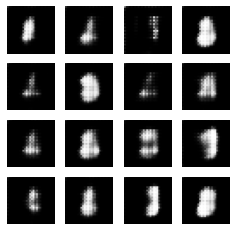

Time for epoch 2 is 6.843544006347656 sec
discriminator loss: -52.34247
generator loss: -450.07562


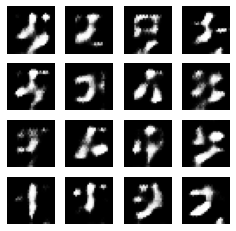

Time for epoch 3 is 6.8830461502075195 sec
discriminator loss: -74.70374
generator loss: -1122.12256


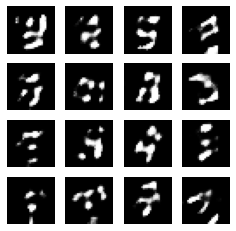

Time for epoch 4 is 6.9152750968933105 sec
discriminator loss: -88.08887
generator loss: -2268.86133


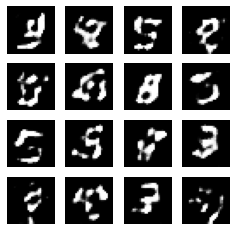

Time for epoch 5 is 6.94337272644043 sec
discriminator loss: -118.10132
generator loss: -2026.62549


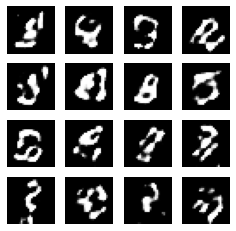

Time for epoch 6 is 6.983267545700073 sec
discriminator loss: -169.39624
generator loss: -1287.33862


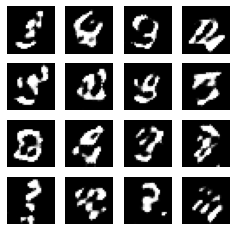

Time for epoch 7 is 6.998033046722412 sec
discriminator loss: -131.50510
generator loss: -143.08331


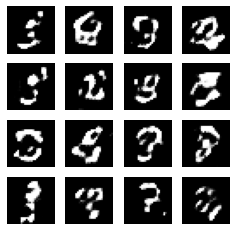

Time for epoch 8 is 7.020620584487915 sec
discriminator loss: -103.72412
generator loss: -1473.69397


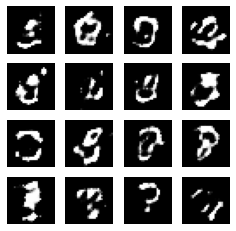

Time for epoch 9 is 7.0393781661987305 sec
discriminator loss: -168.46240
generator loss: -1058.98547


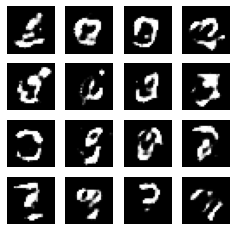

Time for epoch 10 is 7.049839735031128 sec
discriminator loss: -234.58838
generator loss: -2719.04443


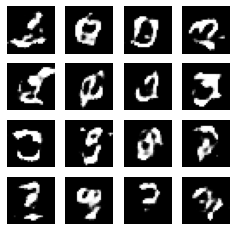

Time for epoch 11 is 7.060836553573608 sec
discriminator loss: -158.73149
generator loss: 138.17175


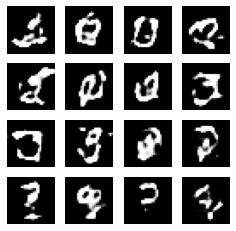

Time for epoch 12 is 7.082601070404053 sec
discriminator loss: -297.35791
generator loss: -3313.60376


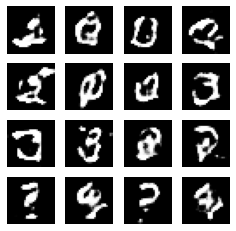

Time for epoch 13 is 7.100741863250732 sec
discriminator loss: -206.23413
generator loss: -1998.96216


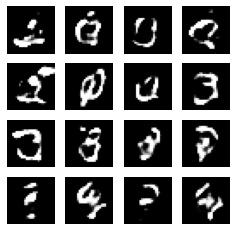

Time for epoch 14 is 7.105701923370361 sec
discriminator loss: -119.04089
generator loss: -731.78796


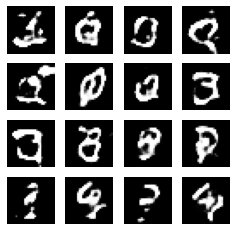

Time for epoch 15 is 7.133595705032349 sec
discriminator loss: -192.94519
generator loss: -1850.17236


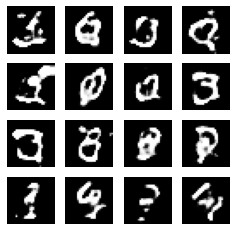

Time for epoch 16 is 7.229326009750366 sec
discriminator loss: -34.42670
generator loss: 566.62073


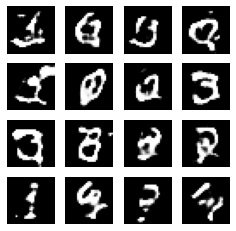

Time for epoch 17 is 7.238017320632935 sec
discriminator loss: -224.89844
generator loss: -4545.29346


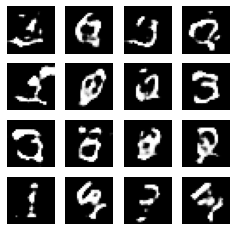

Time for epoch 18 is 7.268691539764404 sec
discriminator loss: -153.31293
generator loss: 772.47791


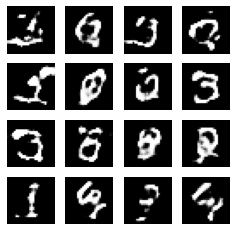

Time for epoch 19 is 7.298911094665527 sec
discriminator loss: -226.80640
generator loss: -656.41107


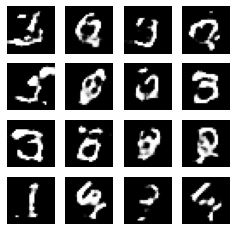

Time for epoch 20 is 7.291092872619629 sec
discriminator loss: -32.11914
generator loss: -3590.38159


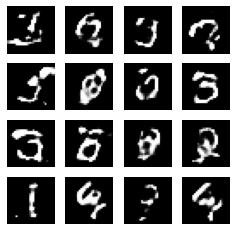

Time for epoch 21 is 7.335794448852539 sec
discriminator loss: -55.89856
generator loss: -1370.03796


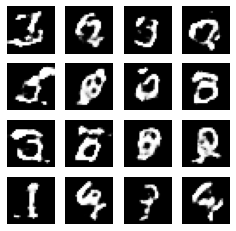

Time for epoch 22 is 7.3124988079071045 sec
discriminator loss: -227.73120
generator loss: -3423.11768


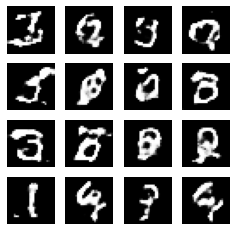

Time for epoch 23 is 7.317439794540405 sec
discriminator loss: 45.26611
generator loss: -5136.35840


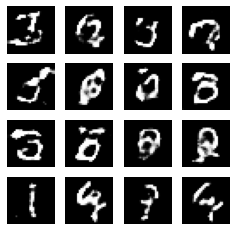

Time for epoch 24 is 7.360914468765259 sec
discriminator loss: 86.45557
generator loss: -1399.06482


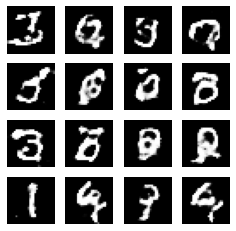

Time for epoch 25 is 7.323056936264038 sec
discriminator loss: -102.65491
generator loss: -599.32336


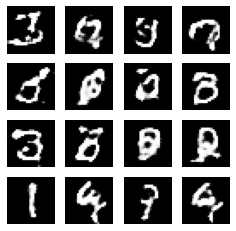

Time for epoch 26 is 7.271107912063599 sec
discriminator loss: 35.05078
generator loss: -5481.17578


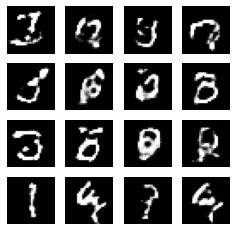

Time for epoch 27 is 7.319432735443115 sec
discriminator loss: 9.49658
generator loss: -5298.01172


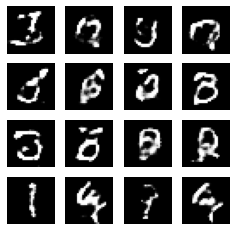

Time for epoch 28 is 7.363375902175903 sec
discriminator loss: -112.41699
generator loss: -5575.83691


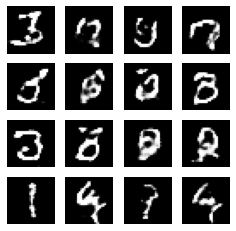

Time for epoch 29 is 7.360934257507324 sec
discriminator loss: -30.43896
generator loss: -6065.35791


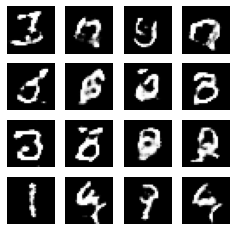

Time for epoch 30 is 7.330808877944946 sec
discriminator loss: 76.14719
generator loss: -552.74902


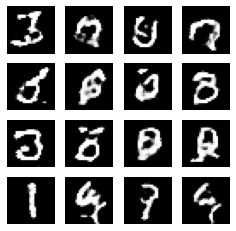

Time for epoch 31 is 7.38855767250061 sec
discriminator loss: -231.68213
generator loss: -5691.74414


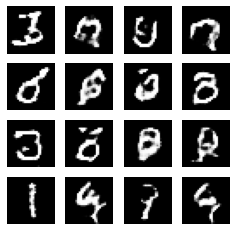

Time for epoch 32 is 7.396825790405273 sec
discriminator loss: 25.44385
generator loss: -5617.41406


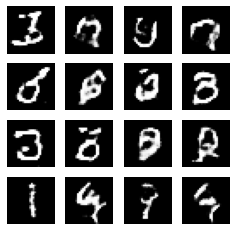

Time for epoch 33 is 7.3925862312316895 sec
discriminator loss: -80.33691
generator loss: -6418.87207


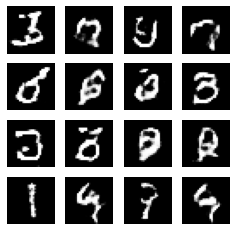

Time for epoch 34 is 7.368751764297485 sec
discriminator loss: -442.97412
generator loss: -5695.64355


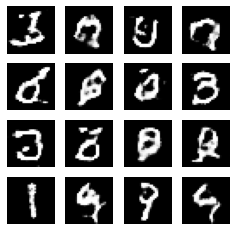

Time for epoch 35 is 7.388255596160889 sec
discriminator loss: -265.81030
generator loss: -643.29443


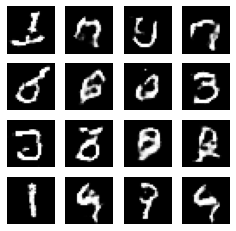

Time for epoch 36 is 7.391068458557129 sec
discriminator loss: -207.62015
generator loss: 709.05011


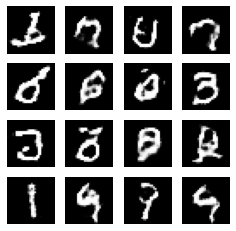

Time for epoch 37 is 7.382967710494995 sec
discriminator loss: -321.25732
generator loss: -5850.31152


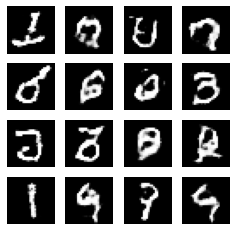

Time for epoch 38 is 7.41411828994751 sec
discriminator loss: 24.16504
generator loss: -4704.96533


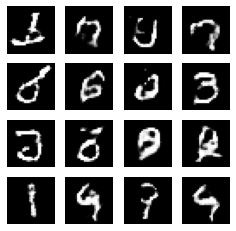

Time for epoch 39 is 7.401970863342285 sec
discriminator loss: 52.47519
generator loss: -457.70996


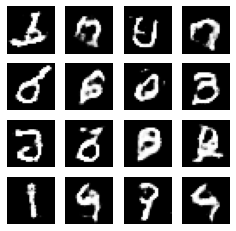

Time for epoch 40 is 7.370410203933716 sec
discriminator loss: 159.24463
generator loss: -5498.76318


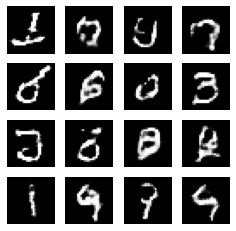

Time for epoch 41 is 7.397776365280151 sec
discriminator loss: -205.12646
generator loss: -6330.11523


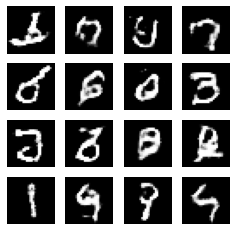

Time for epoch 42 is 7.388115167617798 sec
discriminator loss: -12.71140
generator loss: 362.29700


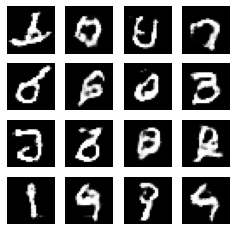

Time for epoch 43 is 7.492860794067383 sec
discriminator loss: -203.34570
generator loss: -6658.80908


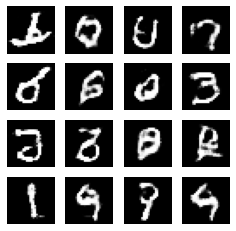

Time for epoch 44 is 7.36362361907959 sec
discriminator loss: 89.82915
generator loss: -278.46579


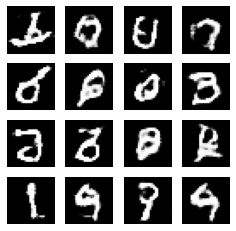

Time for epoch 45 is 7.424907445907593 sec
discriminator loss: 107.87695
generator loss: 97.32351


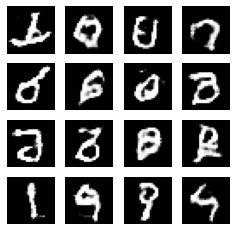

Time for epoch 46 is 7.414195775985718 sec
discriminator loss: 14.04663
generator loss: -2682.96143


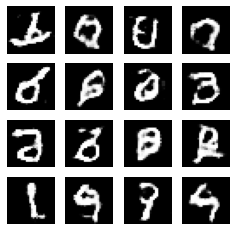

Time for epoch 47 is 7.387861251831055 sec
discriminator loss: -209.61694
generator loss: -3866.63965


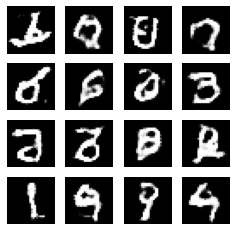

Time for epoch 48 is 7.431753158569336 sec
discriminator loss: 173.94043
generator loss: -5707.56885


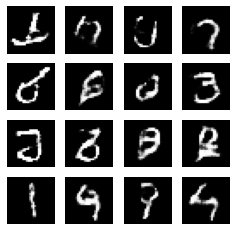

Time for epoch 49 is 7.429047346115112 sec
discriminator loss: -85.14624
generator loss: -3410.64600


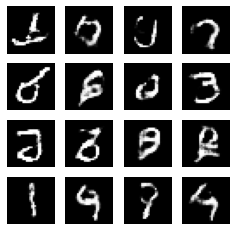

Time for epoch 50 is 7.393805503845215 sec
discriminator loss: 333.05908
generator loss: -7838.05127


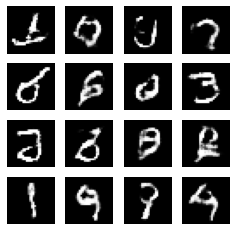

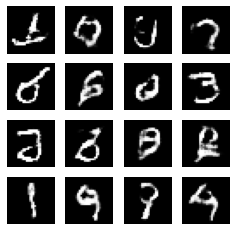

CPU times: user 2min 38s, sys: 14.3 s, total: 2min 52s
Wall time: 6min 28s


In [10]:
%%time
train(train_dataset, EPOCHS)

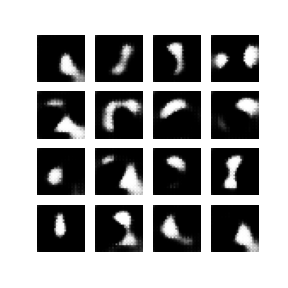

In [11]:
# 使用imageio製作gif圖
anim_file = 'saved_imgs_wgan/wgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:

    filenames = glob.glob('saved_imgs/image*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

display(Image(filename=anim_file))

In [12]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

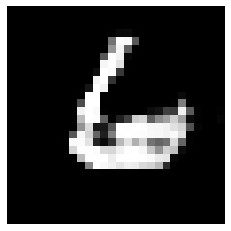

In [13]:
noise = tf.random.normal([1, z_dim])
img = generator(noise, training=False)

plt.imshow(img[0, :, :, 0] * 127.5 + 127.5, cmap='gray')
plt.axis('off')
plt.show()